# Unsupervised Learning

In [144]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.impute import SimpleImputer
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import default_rng

pd.options.display.max_rows = 200
pd.options.display.max_info_columns = 200

In [2]:
train_data = pd.read_parquet('dataset/1-GroupWiseMean/train_groupwise_mean_train_set.parquet')

In [100]:
train_labels = pd.read_csv('dataset/labels/train_labels.csv')
customer_IDs = train_data['customer_ID'].unique()
train_labels = train_labels.loc[train_labels["customer_ID"].isin(customer_IDs)].reset_index(drop=True)
train_labels = train_labels.iloc[:,1].to_numpy()

In [48]:
aggregate_functions = {}
for column in train_data.columns[2:]:
    aggregate_functions[column] = 'mean'

aggregate_train_data = train_data.groupby(train_data["customer_ID"], as_index=False).agg(aggregate_functions)

In [81]:
# impute the missing values with the mean of the features
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
pre_X = aggregate_train_data.iloc[:,1:].to_numpy()
pre_X[pre_X == -1] = np.nan
X = imp_mean.fit(pre_X).transform(pre_X)

# normalize the data
X = preprocessing.normalize(X)

In [82]:
# PCA
pca = PCA(n_components=0.99)
pca_train_components = pca.fit(X).transform(X)

In [91]:
def plot_cumulative_pca_variances(variance_ratio: np.ndarray):
    plt.rcParams["figure.figsize"] = (12,6)

    length = variance_ratio.shape[0]

    fig, ax = plt.subplots()
    xi = np.arange(1, length+1, step=1)
    y = np.cumsum(variance_ratio*100)

    plt.ylim(0.0, 110)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('PCA Components', fontsize=16, labelpad=10)
    plt.ylabel('Cumulative variance (%)', fontsize=16)

    plt.xticks(np.arange(0, length+1, step=2))
    plt.yticks(np.arange(0, 110, step=20))
    plt.tick_params(axis="both",direction="in", pad=10)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    plt.axhline(y=99, color='r', linestyle='-')
    plt.text(0.5, 101, '99% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='both', alpha=0.5)
    plt.show()

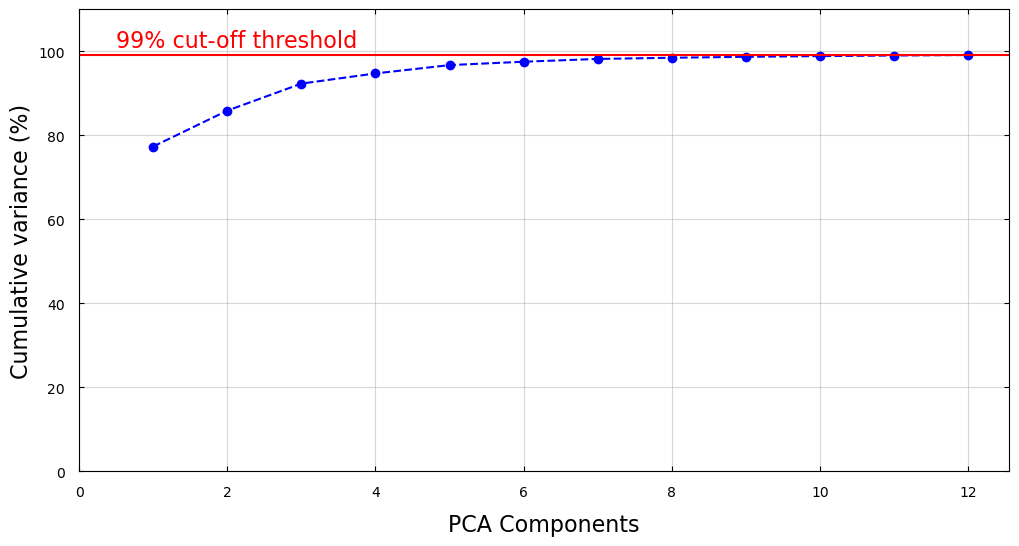

In [92]:
plot_cumulative_pca_variances(pca.explained_variance_ratio_)

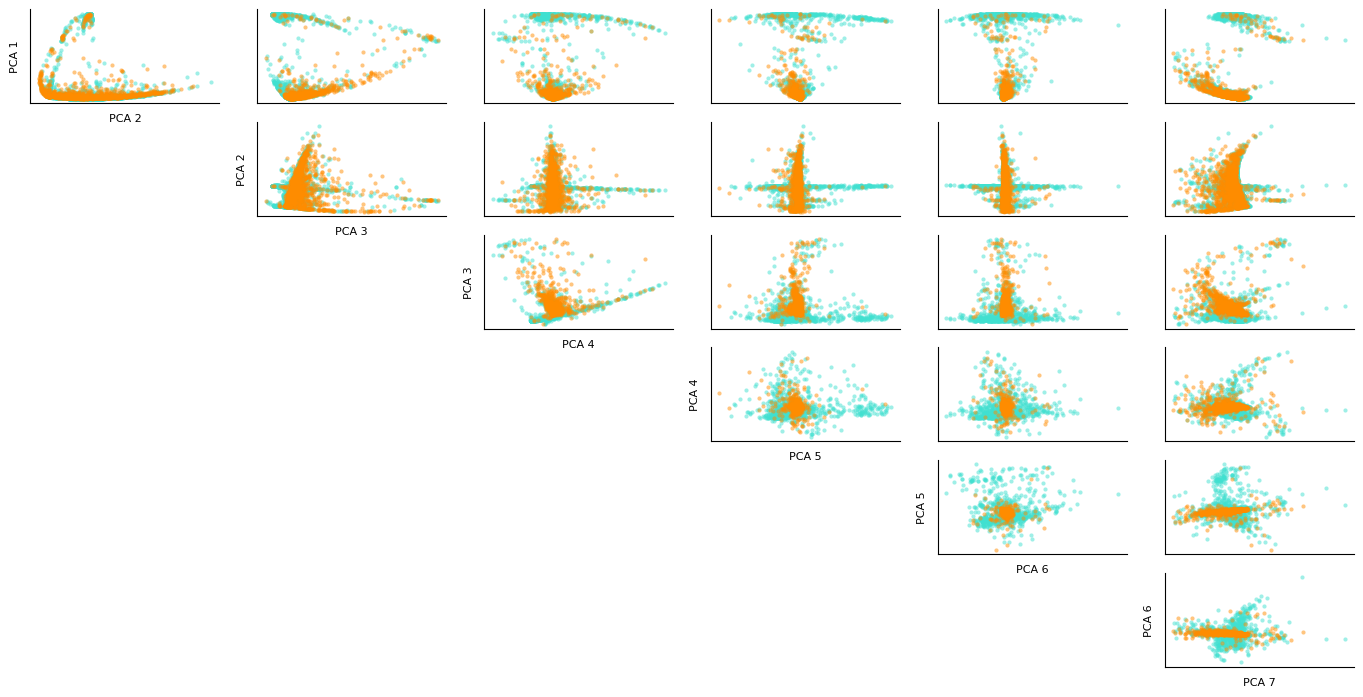

In [168]:
# sampling data to plot
rng = default_rng(seed=2)
idx = rng.choice(np.arange(train_labels.shape[0]), size=5000, replace=False)
data = pca_train_components[idx]
label = train_labels[idx]

plt.rcParams["figure.figsize"] = (20,10)
components = 7
fig, axs = plt.subplots(components, components)
colors = ["turquoise", "darkorange"]

for r in range(components):
    for c in range(r+1, components):
        for color, i in zip(colors, [0, 1]):
            axs[r,c].scatter(
                data[label==i, c], data[label==i, r], 
                s=9, linewidths=0.0, alpha=0.5 ,color=color
            )
        if abs(c-r) == 1:
            axs[r,c].set_xlabel(f"PCA {c+1}", fontsize=8)
            axs[r,c].set_ylabel(f"PCA {r+1}", fontsize=8)

        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].spines.right.set_visible(False)
        axs[r,c].spines.top.set_visible(False)

for r in range(components):
    for c in range(components):
        if r >= c:
            axs[r,c].set_visible(False)

plt.show()

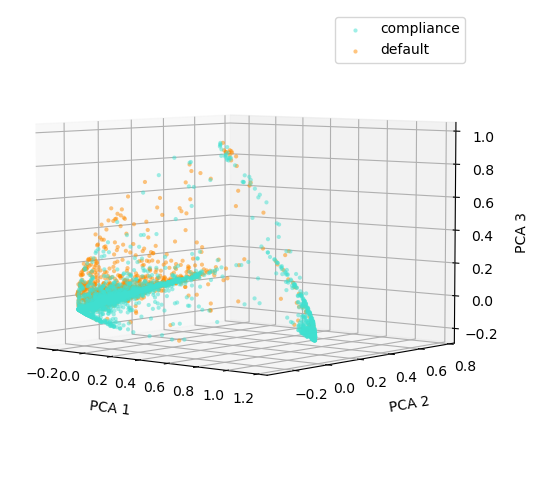

In [165]:
# sampling data to plot
rng = default_rng(seed=2)
idx = rng.choice(np.arange(train_labels.shape[0]), size=5000, replace=False)
data = pca_train_components[idx]
label = train_labels[idx]

plt.rcParams["figure.figsize"] = (12,6)
target_names = ["compliance", "default"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
colors = ["turquoise", "darkorange"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        data[label==i, 0], data[label==i, 1], data[label==i, 2],
        s=9, linewidths=0.0, alpha=0.5 ,color=color, label=target_name
    )

ax.set_xlabel("PCA 1", labelpad=10, rotation=0)
ax.set_ylabel("PCA 2", labelpad=10, rotation=0)
ax.set_zlabel("PCA 3", labelpad=7, rotation=0)

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.view_init(elev=5, azim=-50)

plt.show()

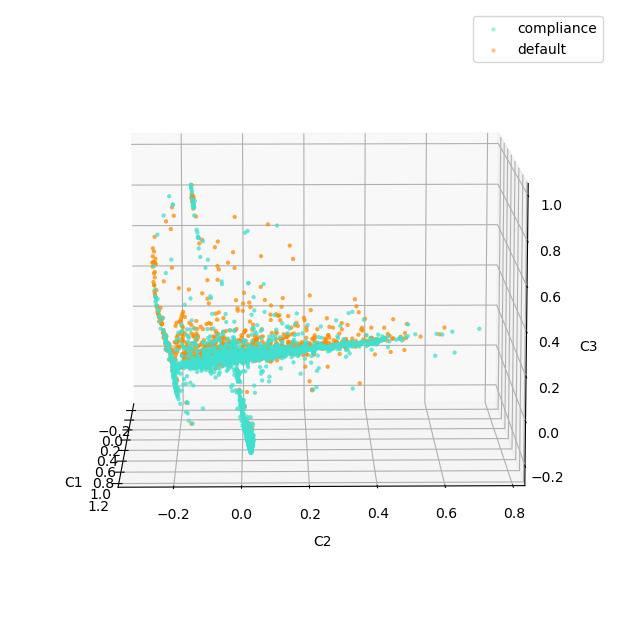

In [162]:
# sample the pca component data
rng = default_rng(seed=2)
idx = rng.choice(np.arange(train_labels.shape[0]), size=5000, replace=False)
data = pca_train_components[idx]
label = train_labels[idx]

# Create a figure and a 3D Axes
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    target_names = ["compliance", "default"]
    colors = ["turquoise", "darkorange"]

    for color, i, target_name in zip(colors, [0, 1], target_names):
        ax.scatter(
            data[label==i, 0], data[label==i, 1], data[label==i, 2],
            s=9, linewidths=0.0, alpha=0.5 ,color=color, label=target_name
        )

    return fig,


def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

ax.set_xlabel("C1", labelpad=10)
ax.set_ylabel("C2", labelpad=10)
ax.set_zlabel("C3", labelpad=10)
ax.legend(loc="best", shadow=False, scatterpoints=1)

# Save
anim.save('images/pca/pca_projection_3D.gif', fps=30)